In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as  xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")



/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#read file
df = pd.read_csv("total_frequency_bydate.csv")
#set data as index
df = df.set_index("date")
#convert date to date type
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,Frequency
date,
2016-01-01,561
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345


<function matplotlib.pyplot.show(close=None, block=None)>

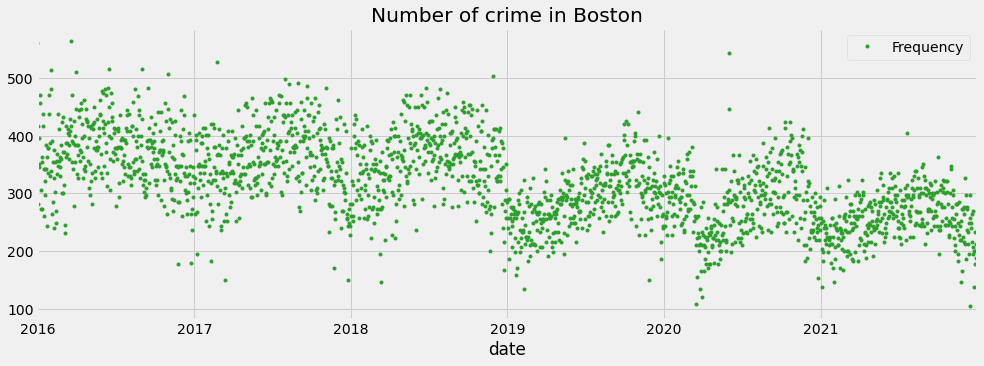

In [4]:
#visualize the data
df.plot(style=".",
        figsize=(15,5),
        color=color_pal[2],
        title="Number of crime in Boston")
plt.show

<AxesSubplot:ylabel='Frequency'>

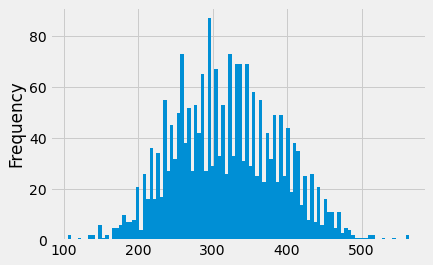

In [9]:
#outlier analysis and removal
#histogram
df['Frequency'].plot(kind="hist",bins=100)

<AxesSubplot:xlabel='date'>

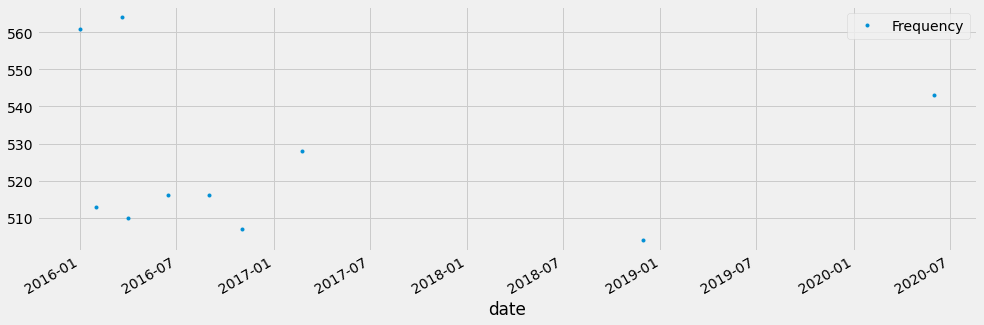

In [23]:
df.query('Frequency >500').plot(figsize=(15,5),style=".")

<AxesSubplot:xlabel='date'>

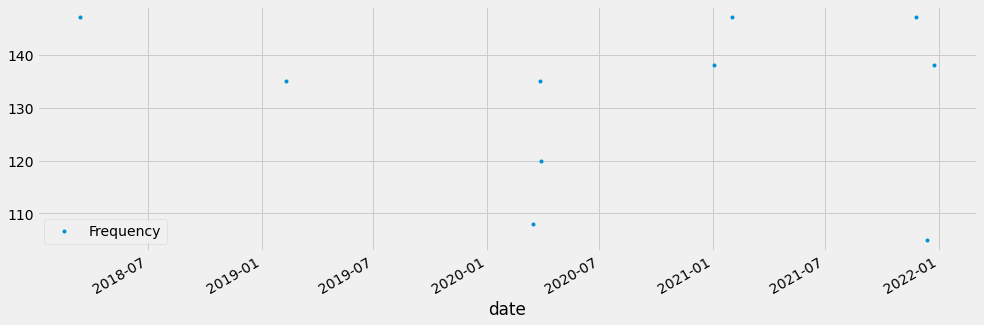

In [22]:
df.query('Frequency < 150').plot(figsize=(15,5),style=".")

In [26]:
#remove outlier
df = df.query('Frequency > 150' and 'Frequency < 500')

df

,Frequency
date,
2016-01-02,417
2016-01-03,282
2016-01-04,351
2016-01-05,345
2016-01-06,396
...,...
2021-12-27,234
2021-12-28,213
2021-12-29,201


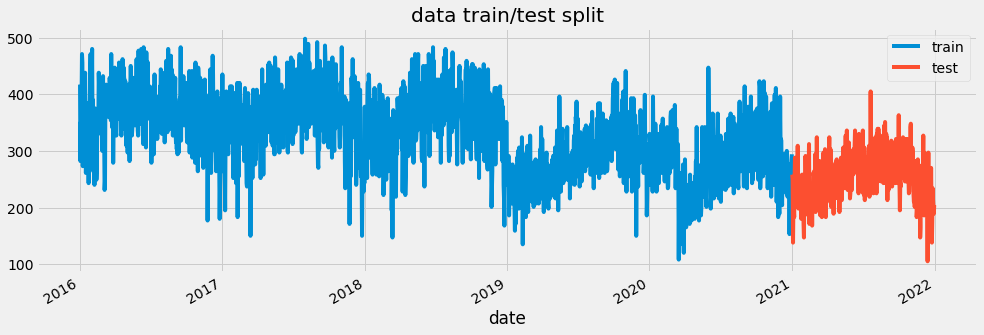

In [27]:
#train test split
train = df.loc[df.index<'01-01-2021']
test = df.loc[df.index>='01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="train",title='data train/test split')
test.plot(ax=ax,label='test')
ax.legend(['train','test'])
plt.show()

In [28]:
#time series cross validation
from sklearn.model_selection import TimeSeriesSplit


In [33]:
#180 days 
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

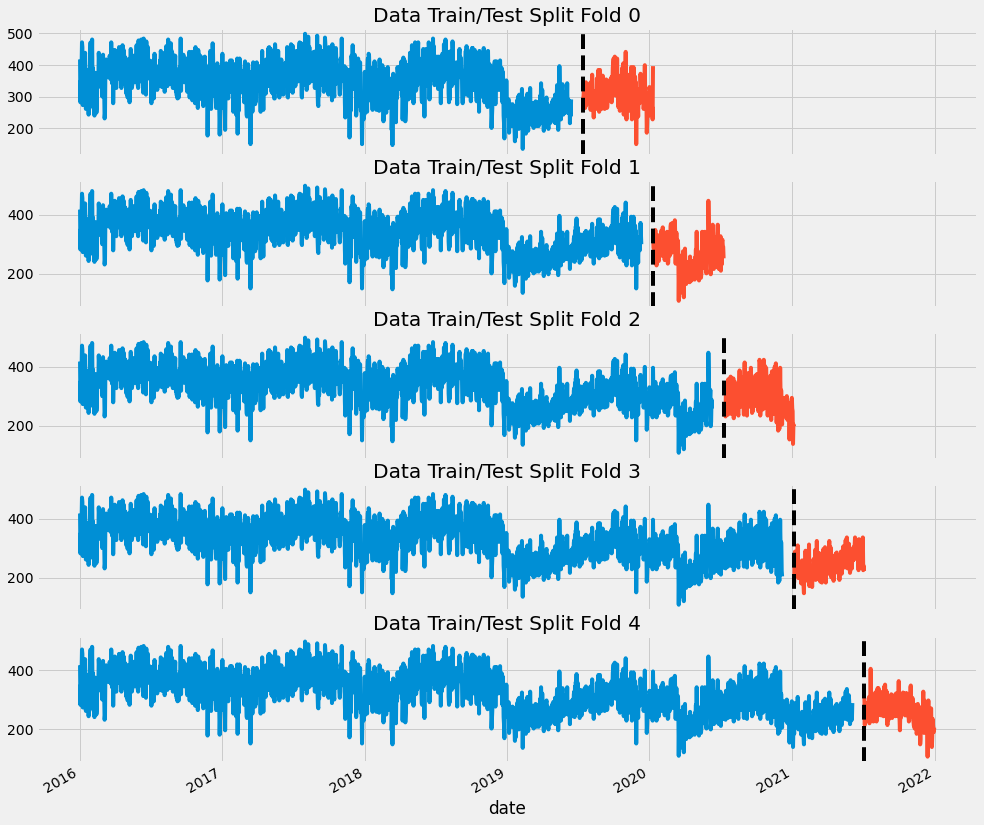

In [37]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Frequency'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Frequency'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [39]:
#forecasting
#feature creation
def create_feature(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['dayofyear'] = df.index.dayofyear
    return df 
df = create_feature(df)



In [43]:
#lag features
target_map = df['Frequency'].to_dict()

In [46]:
def add_lags(df):
    target_map = df['Frequency'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df

In [48]:
df = add_lags(df)

In [53]:
#train use cross validation
tss = TimeSeriesSplit(n_splits=5,test_size=180,gap=30)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Frequency'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gblinear',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[19:20:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:44] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:326.88238	validation_1-rmse:288.54269


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:85.28129	validation_1-rmse:78.42584
[200]	validation_0-rmse:79.13292	validation_1-rmse:69.78861
[300]	validation_0-rmse:75.20898	validation_1-rmse:64.28337
[400]	validation_0-rmse:72.57134	validation_1-rmse:60.72470
[500]	validation_0-rmse:70.70296	validation_1-rmse:58.41988
[600]	validation_0-rmse:69.31491	validation_1-rmse:56.92432
[700]	validation_0-rmse:68.24065	validation_1-rmse:55.97623
[800]	validation_0-rmse:67.38206	validation_1-rmse:55.39085
[900]	validation_0-rmse:66.67802	validation_1-rmse:55.06568
[999]	validation_0-rmse:66.09468	validation_1-rmse:54.91972
[19:20:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:46] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:83.19247	validation_1-rmse:64.89945
[200]	validation_0-rmse:77.35549	validation_1-rmse:65.78273
[300]	validation_0-rmse:73.53632	validation_1-rmse:67.45551
[400]	validation_0-rmse:70.94707	validation_1-rmse:69.21743
[500]	validation_0-rmse:69.12054	validation_1-rmse:70.82033
[600]	validation_0-rmse:67.77891	validation_1-rmse:72.20068
[700]	validation_0-rmse:66.75516	validation_1-rmse:73.36814
[800]	validation_0-rmse:65.94809	validation_1-rmse:74.34885
[900]	validation_0-rmse:65.29417	validation_1-rmse:75.17807
[999]	validation_0-rmse:64.75763	validation_1-rmse:75.87914
[19:20:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:49] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:82.42612	validation_1-rmse:85.48907
[200]	validation_0-rmse:77.09708	validation_1-rmse:78.02974
[300]	validation_0-rmse:73.78702	validation_1-rmse:73.21564
[400]	validation_0-rmse:71.62542	validation_1-rmse:70.06862
[500]	validation_0-rmse:70.13656	validation_1-rmse:67.99165
[600]	validation_0-rmse:69.05763	validation_1-rmse:66.60708
[700]	validation_0-rmse:68.23847	validation_1-rmse:65.68886
[800]	validation_0-rmse:67.59208	validation_1-rmse:65.08683
[900]	validation_0-rmse:67.06578	validation_1-rmse:64.71092
[999]	validation_0-rmse:66.63095	validation_1-rmse:64.49049
[19:20:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:81.27389	validation_1-rmse:45.00005
[200]	validation_0-rmse:76.18794	validation_1-rmse:47.52774
[300]	validation_0-rmse:72.95644	validation_1-rmse:50.30476
[400]	validation_0-rmse:70.82573	validation_1-rmse:52.76760
[500]	validation_0-rmse:69.35902	validation_1-rmse:54.80771
[600]	validation_0-rmse:68.30341	validation_1-rmse:56.46449
[700]	validation_0-rmse:67.51050	validation_1-rmse:57.80904
[800]	validation_0-rmse:66.89177	validation_1-rmse:58.90183
[900]	validation_0-rmse:66.39326	validation_1-rmse:59.80693
[999]	validation_0-rmse:65.98499	validation_1-rmse:60.55854
[19:20:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:20:54] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "early_

/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:80.13539	validation_1-rmse:89.37661
[200]	validation_0-rmse:75.41930	validation_1-rmse:80.32158
[300]	validation_0-rmse:72.50996	validation_1-rmse:74.32560
[400]	validation_0-rmse:70.63335	validation_1-rmse:70.36690
[500]	validation_0-rmse:69.36140	validation_1-rmse:67.80909
[600]	validation_0-rmse:68.45496	validation_1-rmse:66.19215
[700]	validation_0-rmse:67.77822	validation_1-rmse:65.20119
[800]	validation_0-rmse:67.25191	validation_1-rmse:64.63250
[900]	validation_0-rmse:66.82835	validation_1-rmse:64.34720
[999]	validation_0-rmse:66.48136	validation_1-rmse:64.24820


In [55]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')


Score across folds 64.0192
Fold scores:[54.91972140865377, 75.87913569346499, 64.49049163360895, 60.558536070940846, 64.24820128470887]


In [64]:
#predict the future
# Retrain on all data
df = create_feature(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df['Frequency']

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gblinear',    
                       n_estimators=3200,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[19:31:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:31:27] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:576: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:301.16855


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:79.74870
[200]	validation_0-rmse:74.83811
[300]	validation_0-rmse:71.83470
[400]	validation_0-rmse:69.93282
[500]	validation_0-rmse:68.67509
[600]	validation_0-rmse:67.80317
[700]	validation_0-rmse:67.16898
[800]	validation_0-rmse:66.68698
[900]	validation_0-rmse:66.30586
[1000]	validation_0-rmse:65.99464
[1100]	validation_0-rmse:65.73406
[1200]	validation_0-rmse:65.51180
[1300]	validation_0-rmse:65.31956
[1400]	validation_0-rmse:65.15168
[1500]	validation_0-rmse:65.00394
[1600]	validation_0-rmse:64.87341
[1700]	validation_0-rmse:64.75766
[1800]	validation_0-rmse:64.65481
[1900]	validation_0-rmse:64.56325
[2000]	validation_0-rmse:64.48162
[2100]	validation_0-rmse:64.40890
[2200]	validation_0-rmse:64.34392
[2300]	validation_0-rmse:64.28592
[2400]	validation_0-rmse:64.23409
[2500]	validation_0-rmse:64.18778
[2600]	validation_0-rmse:64.14638
[2700]	validation_0-rmse:64.10937
[2800]	validation_0-rmse:64.07623
[2900]	validation_0-rmse:64.04659
[3000]	validation_0-rms

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=-1,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3200, n_jobs=10, num_parallel_tree=None,
             objective='reg:linear', predictor=None, random_state=0,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=None,
             tree_method=None, validate_parameters=1, verbosity=None)

In [67]:
df.index.max()


Timestamp('2021-12-31 00:00:00')

In [68]:
#create future data
future = pd.date_range('2022-01-01','2022-12-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_feature(df_and_future)
df_and_future = add_lags(df_and_future)

In [71]:
future_w_features = df_and_future.query('isFuture').copy()
future_w_features

,Frequency,year,month,dayofmonth,dayofweek,quarter,dayofyear,lag1,lag2,lag3,isFuture
2022-01-01,NaN,2022,1,1,5,1,1,264.0,258.0,237.0,True
2022-01-02,NaN,2022,1,2,6,1,2,327.0,276.0,195.0,True
2022-01-03,NaN,2022,1,3,0,1,3,213.0,243.0,243.0,True
2022-01-04,NaN,2022,1,4,1,1,4,186.0,306.0,237.0,True
2022-01-05,NaN,2022,1,5,2,1,5,297.0,297.0,306.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,2022,12,27,1,4,361,NaN,NaN,NaN,True
2022-12-28,NaN,2022,12,28,2,4,362,NaN,NaN,NaN,True
2022-12-29,NaN,2022,12,29,3,4,363,NaN,NaN,NaN,True
2022-12-30,NaN,2022,12,30,4,4,364,NaN,NaN,NaN,True


In [72]:
#predict future
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])


/Users/simonli/opt/anaconda3/envs/tufts/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


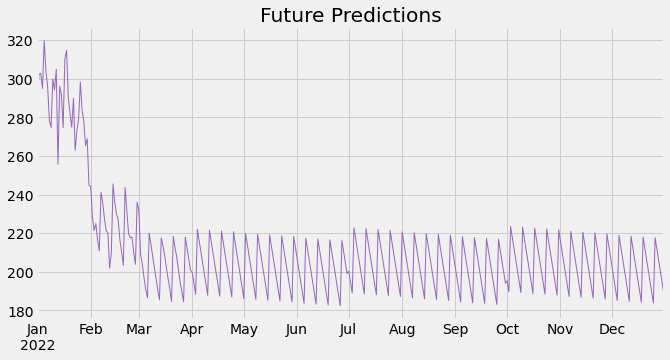

In [73]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()